# Modelo de Regressão VAR

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as ProfileReport
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.regression.linear_model import OLS 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score

### Vamos começar realizando um simples Data Cleaning

In [2]:
df_caminhoes = pd.read_excel("C:/Users/User/Downloads/auto e caminhoes fenabrave.xlsx")
df_energia = pd.read_excel("C:/Users/User/Downloads/consumo de energia.xlsx")

In [3]:
df_caminhoes =df_caminhoes.iloc[7:,0:3].head(10)

In [4]:
df_caminhoes = df_caminhoes.rename(columns=df_caminhoes.iloc[0]).drop(df_caminhoes.index[0]).reset_index(drop=True)

In [5]:
df_energia = df_energia.iloc[7:].reset_index(drop = True)

In [6]:
df_energia.columns = df_energia.iloc[0,:]

In [7]:
df_energia = df_energia.iloc[1:]

In [8]:
df_energia.rename(columns = {'Nome da serie':'Data'},inplace = True)
df_caminhoes.rename(columns = {'Nome da serie':'Data'},inplace = True)

In [9]:
df_energia['Data'] = [pd.to_datetime(i) for i in df_energia['Data']]
df_caminhoes['Data'] = [pd.to_datetime(i) for i in df_caminhoes['Data']]

In [10]:
PIB = pd.read_excel('D:/我的/PIB_IPCA.xlsx','PIB')
IPCA = pd.read_excel('D:/我的/PIB_IPCA.xlsx','IPCA')

### Não foi encontrada uma base de dados para a Alíquota de Imposto de Renda, o que, para o cálculo do consumo, poderia ser essencial! 
Apenas foi encontrado dados do imposto total arrecadado, o que optamos por não utilizar. No entanto, dados sobre o IPCA podem ser úteis, porém as relações serão verificadas no teste de causalidade de Granger

In [11]:
PIB['Data'] = [i.replace('.','-') for i in PIB['Data']]
PIB['Data'] = [pd.to_datetime(i) for i in PIB['Data']]
PIB = PIB.iloc[:,:2]

In [12]:
IPCA['Data'] = [i.replace('.','-') for i in IPCA['Data']]
IPCA['Data'] = [pd.to_datetime(i) for i in IPCA['Data']]
IPCA = IPCA.iloc[:,:2]

In [13]:
import math
PIB['Estação'] = [math.ceil(int(i.strftime('%m'))/3) for i in PIB['Data']]
IPCA['Estação'] = [math.ceil(int(i.strftime('%m'))/3) for i in IPCA['Data']]

In [14]:
PIB_REAL = pd.merge(PIB,IPCA)

In [15]:
df_energia = pd.merge(pd.merge(df_energia,PIB),IPCA)

In [16]:
df_energia.dtypes

Data                                                                                     datetime64[ns]
Consumo de Energia Elétrica Total (EPE)(Nacional)(Original)(Mensal)(Nível)                       object
Consumo de Energia Elétrica Total (EPE)(Região Centro-oeste)(Original)(Mensal)(Nível)            object
Consumo de Energia Elétrica Total (EPE)(Região Sul)(Original)(Mensal)(Nível)                     object
Consumo de Energia Elétrica Total (EPE)(Região Sudeste)(Original)(Mensal)(Nível)                 object
Consumo de Energia Elétrica Total (EPE)(Região Norte)(Original)(Mensal)(Nível)                   object
Consumo de Energia Elétrica Total (EPE)(Região Nordeste)(Original)(Mensal)(Nível)                object
PIB                                                                                             float64
Estação                                                                                           int64
IPCA                                                            

In [18]:
df_energia.rename(columns = {'Consumo de Energia Elétrica Total (EPE)(Nacional)(Original)(Mensal)(Nível)': 'Consumo de Energia Nacional','Consumo de Energia Elétrica Total (EPE)(Região Centro-oeste)(Original)(Mensal)(Nível)':'Consumo de Energia Centro-Oeste','Consumo de Energia Elétrica Total (EPE)(Região Sul)(Original)(Mensal)(Nível)':'Consumo de Energia Sul','Consumo de Energia Elétrica Total (EPE)(Região Sudeste)(Original)(Mensal)(Nível)':'Consumo de Energia Sudeste','Consumo de Energia Elétrica Total (EPE)(Região Norte)(Original)(Mensal)(Nível)':'Consumo de Energia Norte','Consumo de Energia Elétrica Total (EPE)(Região Nordeste)(Original)(Mensal)(Nível)':'Consumo de Energia Nordeste'},inplace=True)

In [19]:
df_energia['Consumo de Energia Nacional'] = pd.to_numeric(df_energia['Consumo de Energia Nacional'])

In [20]:
df_energia

,Data,Consumo de Energia Nacional,Consumo de Energia Centro-Oeste,Consumo de Energia Sul,Consumo de Energia Sudeste,Consumo de Energia Norte,Consumo de Energia Nordeste,PIB,Estação,IPCA
0,2004-01-01,2.697836e+07,1507173.86,4510113.04,14929524.4,1574434.34,4457112.38,144558.6,1,6.04
1,2004-02-01,2.650817e+07,1456012.81,4690227.86,14714713.51,1507448.59,4139768.0,142861.3,1,5.60
2,2004-03-01,2.728433e+07,1534843.53,4898770.4,14903795.68,1574176.69,4372743.11,157363.5,1,5.66
3,2004-04-01,2.804618e+07,1610686.661,4873311.14,15501322.96,1598862.11,4461999.48,156953.9,2,5.85
4,2004-05-01,2.724451e+07,1565788.16,4723026.16,14906628.72,1625478.92,4423584.52,159498.9,2,6.42
...,...,...,...,...,...,...,...,...,...,...
211,2021-08-01,4.062858e+07,3229521.63,7578668.669,19567126.511,3161464.87,7091793.35,739692.2,3,5.43
212,2021-09-01,4.198532e+07,3552433.54,7354639.471,20710207.661,3190894.8,7177144.14,731334.1,3,5.78
213,2021-10-01,4.262215e+07,3600279.44,7451533.11,20798024.23,3219121.3,7553190.45,739982.7,4,6.45
214,2021-11-01,4.193184e+07,3364580.54,7615013.091,20301925.39,3178834.95,7471483.22,755731.3,4,6.16


In [21]:
%matplotlib inline 

## Agora que as bases de dados estão unidas, vamos dar uma olhada em como as séries estão atualmente!

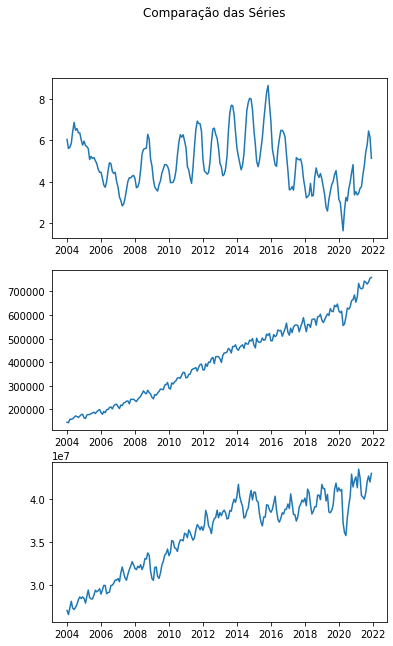

In [81]:
fig, axs = plt.subplots(3,figsize=(6,10))
fig.suptitle('Comparação das Séries')
axs[0].plot(df_energia['Data'], df_energia['IPCA'])
axs[1].plot(df_energia['Data'],df_energia['PIB'])
axs[2].plot(df_energia['Data'],df_energia['Consumo de Energia Nacional'])

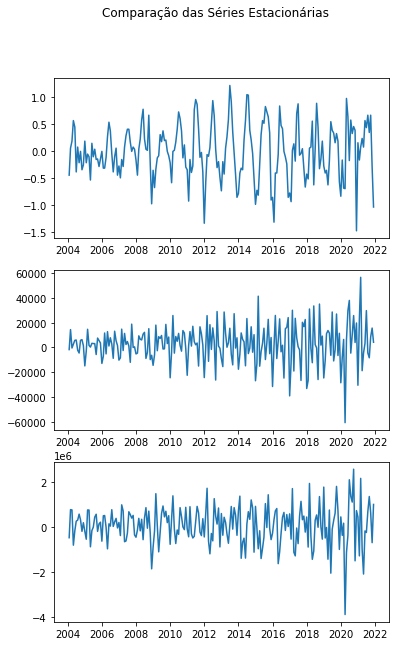

In [80]:
fig, axs = plt.subplots(3,figsize=(6,10))
fig.suptitle('Comparação das Séries Estacionárias')
axs[0].plot(df_energia['Data'], df_energia['IPCA'].diff())
axs[1].plot(df_energia['Data'],df_energia['PIB'].diff())
axs[2].plot(df_energia['Data'],df_energia['Consumo de Energia Nacional'].diff())

In [24]:
df_energia['Consumo de Energia Nacional Var'] = df_energia['Consumo de Energia Nacional'] - df_energia['Consumo de Energia Nacional'].shift(1) 

In [25]:
df_energia['PIB_Var'] = df_energia['PIB'] - df_energia['PIB'].shift(1)   

### Viu-se, o que parecia ser, uma alta correlação entre o PIB e o Consumo de Energia Nacional

In [26]:
df_energia[['Consumo de Energia Nacional','IPCA','PIB']].corr()

,Consumo de Energia Nacional,IPCA,PIB
Consumo de Energia Nacional,1.000000,-0.012009,0.933297
IPCA,-0.012009,1.000000,-0.101260
PIB,0.933297,-0.101260,1.000000


#  Segundo a Macroeconomia...
### Consumo = Co + C1*(Ydisponível)
### Ydisponível(Y,Taxa de Impostos)
### Y = C + I + G + (X - M)
### Ambas variáveis se afetam simultaneamente!

Ao analisar o gráfico do IPCA, ele não aparenta possuir nenhuma tendência específica, portanto optamos por não colocá-lo na primeira diferença. Vamos, porém, realizar o teste adfuller para descobrir se vale ou não a pena realizar esse procedimeto!

In [27]:
ad_fuller_result_1 = adfuller(df_energia['Consumo de Energia Nacional Var'][1:])
ad_fuller_result_2 = adfuller(df_energia['IPCA'])
ad_fuller_result_3 = adfuller(df_energia['PIB_Var'][1:])

Ad_fuller = pd.DataFrame({'Energia Consumo':[ad_fuller_result_1[0],ad_fuller_result_1[1]],'IPCA':[ad_fuller_result_2[0],ad_fuller_result_2[1]], 'PIB':[ad_fuller_result_3[0],ad_fuller_result_3[1]]})
Ad_fuller.rename(index={0:'ADF Statistic',1:'p-value'},inplace=True)

Ad_fuller

,Energia Consumo,IPCA,PIB
ADF Statistic,-4.421987,-2.498599,-4.302433
p-value,0.000271,0.115816,0.000440


O IPCA aparenta não ser estacionário, vamos colocá-lo na primeira diferença para que ele se torne!

In [28]:
df_energia['IPCA_Var'] = df_energia['IPCA'].diff()

## Teste de Causalidade de Granger para ver quais variáveis afetam o Consumo de Energia

In [29]:
print('O Consumo de Energia Afeta o PIB?\n')
print('-------------------------------')
granger_1 = grangercausalitytests(df_energia[['PIB_Var','Consumo de Energia Nacional Var']][1:],2)
print('\n-------------------------------\n')
print('PIB Afeta o Consumo de Energia?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_energia[['Consumo de Energia Nacional Var','PIB_Var']][1:],2)
print('\n-------------------------------\n')
print('IPCA Afeta o Consumo de Energia?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_energia[['Consumo de Energia Nacional Var','IPCA_Var']][1:],2)
print('\n-------------------------------\n')
print('O Consumo de Energia Afeta o IPCA?\n')
print('-------------------------------')
granger_2 = grangercausalitytests(df_energia[['IPCA_Var','Consumo de Energia Nacional Var']][1:],2)



O Consumo de Energia Afeta o PIB?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2123  , p=0.0135  , df_denom=211, df_num=1
ssr based chi2 test:   chi2=6.3006  , p=0.0121  , df=1
likelihood ratio test: chi2=6.2096  , p=0.0127  , df=1
parameter F test:         F=6.2123  , p=0.0135  , df_denom=211, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8190  , p=0.0014  , df_denom=208, df_num=2
ssr based chi2 test:   chi2=13.9658 , p=0.0009  , df=2
likelihood ratio test: chi2=13.5271 , p=0.0012  , df=2
parameter F test:         F=6.8190  , p=0.0014  , df_denom=208, df_num=2

-------------------------------

PIB Afeta o Consumo de Energia?

-------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2536  , p=0.0404  , df_denom=211, df_num=1
ssr based chi2 test:   chi2=4.3141  , p=0.0378  , df=1
likelihood ratio test: chi2=4.2712  , p=0.0388  , df=1
p

### Foi possível verificar que não há uma relação muito significativa do IPCA com a nossa variável principal de interesse do estudo (Consumo de Energia Elétrica), no primeiro LAG. como consequência disso, iremos retirá-la do modelo.

# Agora, vamos separar o nosso modelo em Treino e Teste!

In [30]:
train_df = df_energia[['PIB','Consumo de Energia Nacional']][:-24]
test_df = df_energia[['PIB','Consumo de Energia Nacional']][-24:]

In [31]:
model = VAR(train_df.diff()[1:])
sorted_order = model.select_order(maxlags=20)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        46.29       46.33   1.275e+20       46.31
1        46.23       46.34   1.195e+20       46.27
2        45.97       46.15   9.209e+19       46.04
3        45.79       46.05   7.702e+19       45.89
4        45.76       46.09   7.500e+19       45.90
5        45.57       45.98   6.186e+19       45.74
6        45.37       45.84   5.040e+19       45.56
7        45.29       45.84   4.678e+19       45.51
8        45.18       45.81   4.208e+19       45.44
9        45.13       45.83   3.994e+19       45.42
10       45.04       45.81   3.630e+19       45.35
11       44.82       45.67   2.933e+19       45.16
12       44.74       45.66   2.697e+19       45.11
13       44.66      45.65*   2.505e+19      45.06*
14       44.66       45.72   2.494e+19       45.09
15       44.68       45.82   2.567e+19       45.15
16       44.65       45.87   2.

d:\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:590: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


## Nesse gráfico, é possível verificar que o modelo está nos recomendando utilizar um total de 17 Lags em 2 das colunas, o que é o que iremos fazer!

In [32]:
var_model = VARMAX(train_df,order =(17,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     Statespace Model Results                                     
Dep. Variable:     ['PIB', 'Consumo de Energia Nacional']   No. Observations:                  192
Model:                                            VAR(17)   Log Likelihood               -6367.855
                                              + intercept   AIC                          12881.709
Date:                                    Mon, 07 Mar 2022   BIC                          13119.506
Time:                                            15:58:00   HQIC                         12978.019
Sample:                                                 0                                         
                                                    - 192                                         
Covariance Type:                                      opg                                         
Ljung-Box (L1) (Q):         114.13, 140.67   Jarque-Bera (JB):         202.44, 0.71
Prob(Q):                 

In [33]:
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
predictions = predict.predicted_mean

In [34]:
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)

In [35]:
test_vs_pred = pd.concat([test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']],axis=1)

<AxesSubplot:>

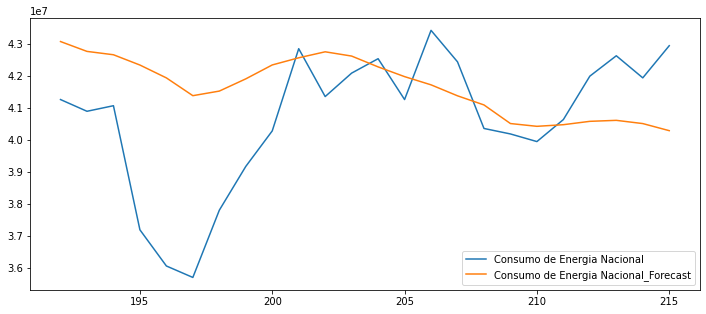

In [36]:
test_vs_pred.plot(figsize=(12,5))

### Agora vamos ver como nossas primeiras estimativas para o futuro ficaram ;)

d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


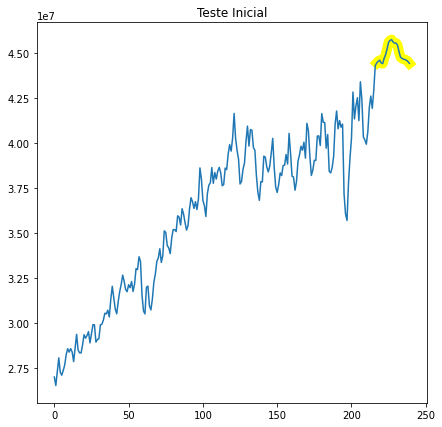

In [73]:
var_model = VARMAX(df_energia[['PIB','Consumo de Energia Nacional']],order =(17,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(df_energia),end=len(df_energia) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
Forecast = pd.concat([df_energia['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']])
fig, axs = plt.subplots(1,figsize=(7,7))

axs.plot(Forecast[217:240], lw=10, c='yellow', zorder=-1)
axs.plot(Forecast)
axs.title.set_text(f'Teste Inicial')

## Realizando o teste do melhor modelo LEVANDO EM CONSIDERAÇÃO OS CRITÉRIOS DE AIC, MAPE, MSE e MAE.

In [50]:
l = []
for i in range(1,18):
    if i != 7:
        var_model = VARMAX(train_df,order =(i,0), enforce_stationarity=True)
        fitted_model = var_model.fit(disp=False)
        predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
        predictions = predict.predicted_mean
        predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
        print(f'\n------------------------\n LAG Número {i}\n')
        print(f"MAE: {mean_absolute_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6}")
        print(f"MSE: {mean_squared_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6}")
        print(f"MAPE: {mean_absolute_percentage_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])}")
        print(f"AIC: {fitted_model.aic}")
        print('\n------------------------')
        l.append({f'{i} LAGs:':[mean_absolute_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6,mean_squared_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**9,mean_absolute_percentage_error(test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']),fitted_model.aic]})


------------------------
 LAG Número 1

MAE: 1.6018943031315946
MSE: 5276503.329718743
MAPE: 0.04152205956905416
AIC: 9962.841499478547

------------------------

------------------------
 LAG Número 2

MAE: 1.61162695369461
MSE: 5334189.465640106
MAPE: 0.04177192399042282
AIC: 9951.994585239932

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



------------------------
 LAG Número 3

MAE: 2.068655953144419
MSE: 7593467.586692094
MAPE: 0.053252865059466185
AIC: 11411.109068829452

------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



------------------------
 LAG Número 4

MAE: 2.053715984900794
MSE: 7872186.210517305
MAPE: 0.052617250446075715
AIC: 11365.925541643102

------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 5

MAE: 2.242317278045643
MSE: 9683344.576813491
MAPE: 0.05789084550258117
AIC: 11360.439515603632

------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 6

MAE: 1.6985185841253754
MSE: 5090574.383250363
MAPE: 0.042926834530526946
AIC: 9846.855029024166

------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 8

MAE: 1.6935115473102003
MSE: 4838019.533562556
MAPE: 0.042633394872895414
AIC: 9794.733225058186

------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 9

MAE: 1.483489675051585
MSE: 4026485.5217817384
MAPE: 0.037479585348695416
AIC: 9777.512287164722

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 10

MAE: 2.460030992945715
MSE: 11338718.495673236
MAPE: 0.06347060237692102
AIC: 12190.596995436652

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 11

MAE: 2.717489437024455
MSE: 14434055.863413123
MAPE: 0.07048982343773888
AIC: 11961.826223724367

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 12

MAE: 3.4622296058056405
MSE: 18281956.42125098
MAPE: 0.08870833171824329
AIC: 12435.675205952246

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 13

MAE: 3.0716021355021446
MSE: 14187722.267229125
MAPE: 0.0785884940064187
AIC: 13149.559994592197

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



------------------------
 LAG Número 14

MAE: 5.391160003853566
MSE: 33406901.279443253
MAPE: 0.13017317407256368
AIC: 12807.960327438203

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 15

MAE: 2.328108110911928
MSE: 9617033.015237221
MAPE: 0.059990164252479765
AIC: 12528.631870778852

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 16

MAE: 2.460258658160197
MSE: 9807252.42734307
MAPE: 0.06320330586875454
AIC: 12168.893479517454

------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



------------------------
 LAG Número 17

MAE: 1.9027433905597364
MSE: 6300675.641975816
MAPE: 0.048685743019610976
AIC: 12881.709023466337

------------------------


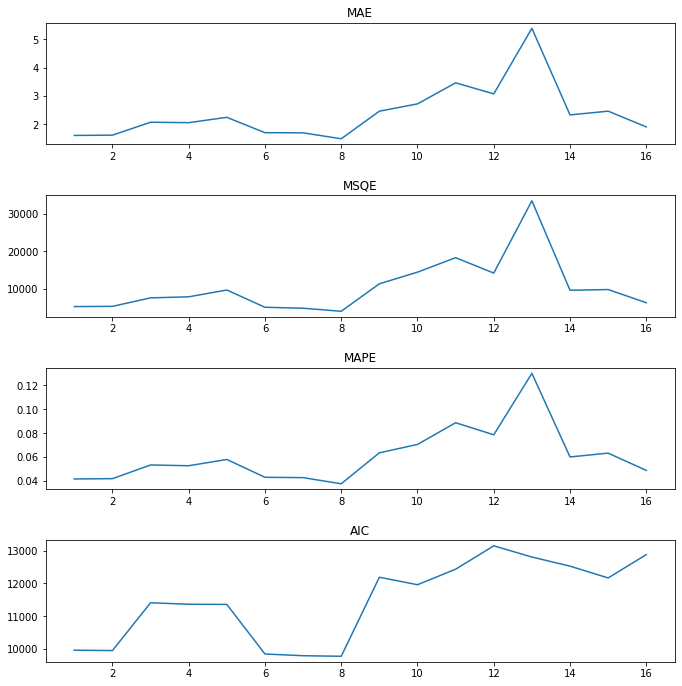

In [67]:
lista2 = []
for i in range(4):
    lista = []
    for k in range(0,16):
        lista.append(list(l[k].values())[0][i])
    lista2.append(lista)
Dados2 = pd.DataFrame([lista2[0],lista2[1],lista2[2],lista2[3]])
Dados2.columns = Dados2.columns + 1
fig, axs = plt.subplots(4, figsize=(10,10))
fig.tight_layout(pad=3.0)
axs[0].title.set_text("MAE")
axs[1].title.set_text("MSQE")
axs[2].title.set_text("MAPE")
axs[3].title.set_text("AIC")
axs[0].plot(Dados2.iloc[0,:])
axs[1].plot(Dados2.iloc[1,:])
axs[2].plot(Dados2.iloc[2,:])
axs[3].plot(Dados2.iloc[3,:])

# ATENÇÃO!
A partir do 7 no eixo X, esse valor terá que ser somado por 1 para obter o verdadeiro LAG, pois nós excluímos o LAG7 devido a erros que estavam ocorrendo.

## Depois de testar, vamos ver o quanto nosso modelo acertou em um gráfico!
#### E claro, comparar ele com o modelo passado!

In [63]:
var_model = VARMAX(train_df,order =(9,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
test_vs_pred_após_teste = pd.concat([test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']],axis=1)

d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


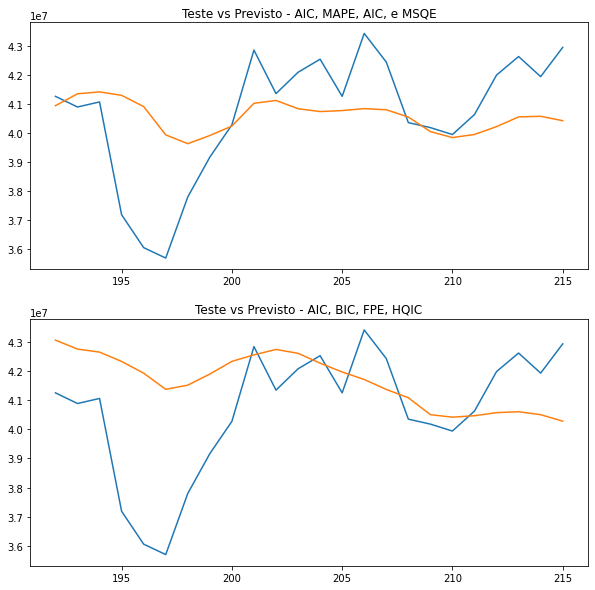

In [64]:
fig, axs = plt.subplots(2, figsize = (10,10))
axs[0].plot(test_vs_pred_após_teste)
axs[0].title.set_text("Teste vs Previsto - AIC, MAPE, AIC, e MSQE")
axs[1].plot(test_vs_pred)
axs[1].title.set_text("Teste vs Previsto - AIC, BIC, FPE, HQIC")

## Agora, vamos utilizar 9 LAGs para obter as nossas estimativas para o Consumo de Energia no Futuro ;)

In [68]:
var_model = VARMAX(df_energia[['PIB','Consumo de Energia Nacional']],order =(9,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(df_energia),end=len(df_energia) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)

d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Agora vamos ver como nossas segundas estimativas ficaram em um gráfico (Bem Visual!)

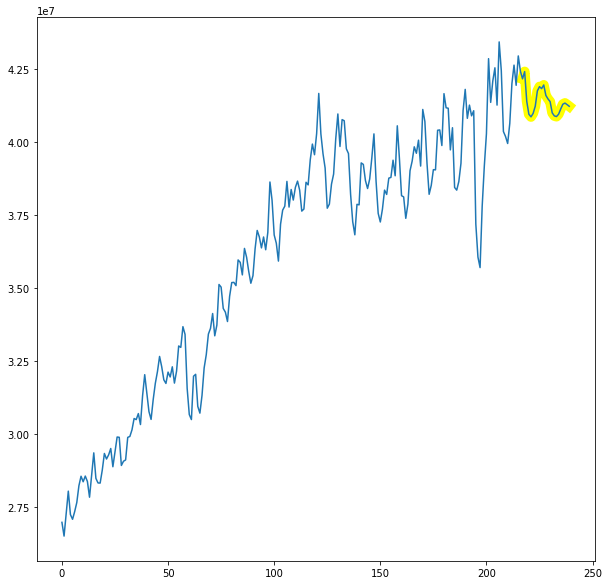

In [70]:
Forecast = pd.concat([df_energia['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']])
fig, axs = plt.subplots(1,figsize=(6,6))
axs.plot(Forecast[217:240], lw=10, c='yellow', zorder=-1)
axs.plot(Forecast)

### Mas será que ainda é OVERFIT???

# Ficamos interessados em realizar um teste de validação cruzada para ver qual LAG, de fato, seria o melhor.
### As métricas a serem usadas serão o MAE, MSQE, MAPE, e o AIC. 
Selecionamos um total de 20 testes. Nosso primeiro modelo se utilizará de 8 anos e 1 mês para prever 2 anos na frente. Logo após, usaremos 8 anos e 6 meses para prever 2 anos na frente. Isso continuará até o final da nossa base de dados.

In [74]:
lista = [] # Lista que armazenará cada avaliação cruzada
for i in range(20):
    df_treino_CV = df_energia[['PIB','Consumo de Energia Nacional']][:-24-i*5]
    if i != 0:
        df_teste_CV = df_energia[['PIB','Consumo de Energia Nacional']][-24-i*5:-i*5]
    else:
        df_teste_CV = df_energia[['PIB','Consumo de Energia Nacional']][-24-i*5:]
    
    print(df_treino_CV.shape)
    print(df_teste_CV.shape)
    print(f'\n------------------\n Cross-Validation número {i}\n---------------------\n\n')

    l = [] # Lista que armazenará todos os LAGs
    for j in range(1,13):
        if j != 7:
            #Realizando o modelo denovo, ele rodará cerca de 240 vezes!
            var_model = VARMAX(df_treino_CV,order =(j,0), enforce_stationarity=True)
            fitted_model = var_model.fit(disp=False)
            predict = fitted_model.get_prediction(start=len(df_treino_CV),end=len(df_treino_CV) + 24 -1)
            predictions = predict.predicted_mean
            predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
            # Adicionando comentários para manter certeza de que o modelo está rodando, de fato, e que não deu erro.
            print(f'LAG sendo Testado: {j}')
            print(f"MAE: {mean_absolute_error(df_teste_CV['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6}")
            print(f"MSE: {mean_squared_error(df_teste_CV['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6}")
            print(f"MAPE: {mean_squared_error(df_teste_CV['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])}")
            print(f"AIC: {fitted_model.aic}")
            print('------------------------')
            #Adicionando todos esses valores às listas. Utilizarei elas depois para plotar os gráficos com as estatísticas.
            l.append({f'{j} LAGs:':[mean_absolute_error(df_teste_CV['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**6,mean_squared_error(df_teste_CV['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast'])/10**10, mean_absolute_percentage_error(df_teste_CV['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']),fitted_model.aic]})            
    lista.append({f'Cross{i}':l})


(192, 2)
(24, 2)

------------------
 Cross-Validation número 0
---------------------


LAG sendo Testado: 1
MAE: 1.6018943031315946
MSE: 5276503.329718743
MAPE: 5276503329718.743
AIC: 9962.841499478547
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 2
MAE: 1.61162695369461
MSE: 5334189.465640106
MAPE: 5334189465640.106
AIC: 9951.994585239932
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 2.068655953144419
MSE: 7593467.586692094
MAPE: 7593467586692.094
AIC: 11411.109068829452
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 2.053715984900794
MSE: 7872186.210517305
MAPE: 7872186210517.305
AIC: 11365.925541643102
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 2.242317278045643
MSE: 9683344.576813491
MAPE: 9683344576813.49
AIC: 11360.439515603632
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.6985185841253754
MSE: 5090574.383250363
MAPE: 5090574383250.363
AIC: 9846.855029024166
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.6935115473102003
MSE: 4838019.533562556
MAPE: 4838019533562.556
AIC: 9794.733225058186
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.483489675051585
MSE: 4026485.5217817384
MAPE: 4026485521781.7383
AIC: 9777.512287164722
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 2.460030992945715
MSE: 11338718.495673236
MAPE: 11338718495673.236
AIC: 12190.596995436652
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 2.717489437024455
MSE: 14434055.863413123
MAPE: 14434055863413.123
AIC: 11961.826223724367
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 3.4622296058056405
MSE: 18281956.42125098
MAPE: 18281956421250.98
AIC: 12435.675205952246
------------------------
(187, 2)
(24, 2)

------------------
 Cross-Validation número 1
---------------------


LAG sendo Testado: 1
MAE: 1.5214425605871251
MSE: 4102079.2200530972
MAPE: 4102079220053.097
AIC: 9702.100825863083
------------------------
LAG sendo Testado: 2
MAE: 1.5459389640926051
MSE: 4075973.070307079
MAPE: 4075973070307.0786
AIC: 9691.281132775483
------------------------
LAG sendo Testado: 3
MAE: 1.5971791680357013
MSE: 5320723.229377982
MAPE: 5320723229377.982
AIC: 9652.651696273573
------------------------
LAG sendo Testado: 4
MAE: 1.5211757630110105
MSE: 3878984.205562418
MAPE: 3878984205562.418
AIC: 9640.665919373987
------------------------
LAG sendo Testado: 5
MAE: 1.5070130397062798
MSE: 3766392.7263365546
MAPE: 3766392726336.5547
AIC: 9636.891413299662
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.4948483947211075
MSE: 3959382.0972543047
MAPE: 3959382097254.3047
AIC: 9584.96122500173
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.281803012486537
MSE: 3396271.066395512
MAPE: 3396271066395.5117
AIC: 9546.58802048413
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.2131083678760683
MSE: 3036732.5348016135
MAPE: 3036732534801.614
AIC: 9526.745984720921
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 2.1497641126462357
MSE: 6904233.28355302
MAPE: 6904233283553.0205
AIC: 11589.525178315687
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 2.3349892784775714
MSE: 8676981.762104364
MAPE: 8676981762104.364
AIC: 11752.557647312864
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 2.1680730052860273
MSE: 7837617.244156806
MAPE: 7837617244156.806
AIC: 11509.54927481266
------------------------
(182, 2)
(24, 2)

------------------
 Cross-Validation número 2
---------------------


LAG sendo Testado: 1
MAE: 1.6147683717133647
MSE: 4415877.916521777
MAPE: 4415877916521.777
AIC: 9429.606170681724
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 2
MAE: 1.6077989834624522
MSE: 4170935.553372358
MAPE: 4170935553372.358
AIC: 9420.35497675544
------------------------
LAG sendo Testado: 3
MAE: 1.9401896002333443
MSE: 6660648.964660062
MAPE: 6660648964660.0625
AIC: 9378.247640353771
------------------------
LAG sendo Testado: 4
MAE: 1.699231998835698
MSE: 5545796.836207607
MAPE: 5545796836207.606
AIC: 9366.080314032926
------------------------
LAG sendo Testado: 5
MAE: 1.5635029489406758
MSE: 4437923.499138705
MAPE: 4437923499138.705
AIC: 9362.14132404845
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.6772464745916191
MSE: 3992040.309363453
MAPE: 3992040309363.453
AIC: 9310.342911501917
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.6561047644380014
MSE: 4037038.78371356
MAPE: 4037038783713.56
AIC: 9269.882508351155
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.4608329563009574
MSE: 3409925.303688203
MAPE: 3409925303688.203
AIC: 9256.181021406126
------------------------
LAG sendo Testado: 10
MAE: 1.3750676153864805
MSE: 3391081.954764638
MAPE: 3391081954764.638
AIC: 9250.625620514287
------------------------
LAG sendo Testado: 11
MAE: 1.4118956833959286
MSE: 3242190.163058797
MAPE: 3242190163058.797
AIC: 9234.000350434158
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 2.0196162365810837
MSE: 6358879.593483779
MAPE: 6358879593483.778
AIC: 11192.501290537562
------------------------
(177, 2)
(24, 2)

------------------
 Cross-Validation número 3
---------------------


LAG sendo Testado: 1
MAE: 1.4260825376117696
MSE: 3076672.471261826
MAPE: 3076672471261.8257
AIC: 9160.231441287271
------------------------
LAG sendo Testado: 2
MAE: 1.452234881164485
MSE: 2805640.293863854
MAPE: 2805640293863.854
AIC: 9150.402191645779
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 3
MAE: 1.456113213093251
MSE: 4268359.303042065
MAPE: 4268359303042.065
AIC: 9110.45612553247
------------------------
LAG sendo Testado: 4
MAE: 1.4568168839806281
MSE: 3302116.6265184726
MAPE: 3302116626518.4727
AIC: 9100.175952430163
------------------------
LAG sendo Testado: 5
MAE: 1.4643754269690386
MSE: 3008762.5791681344
MAPE: 3008762579168.1343
AIC: 9094.66246507212
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.469608947050716
MSE: 3038194.4147811364
MAPE: 3038194414781.136
AIC: 9040.573196399264
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.338373177584026
MSE: 2538843.609165045
MAPE: 2538843609165.045
AIC: 9001.718877137006
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.2666617593581875
MSE: 2302016.309455906
MAPE: 2302016309455.9062
AIC: 8988.065097707808
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.273723835522524
MSE: 2308041.7098276857
MAPE: 2308041709827.6855
AIC: 8985.299680286127
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.4184327156378664
MSE: 2810841.7941134498
MAPE: 2810841794113.4497
AIC: 8962.806973579325
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.6222551936311778
MSE: 3356350.065956215
MAPE: 3356350065956.215
AIC: 8954.50373000939
------------------------
(172, 2)
(24, 2)

------------------
 Cross-Validation número 4
---------------------


LAG sendo Testado: 1
MAE: 1.2168106313438565
MSE: 2073185.6827310887
MAPE: 2073185682731.0886
AIC: 8893.688838802827
------------------------
LAG sendo Testado: 2
MAE: 1.1903981340466503
MSE: 1914908.8877723797
MAPE: 1914908887772.3796
AIC: 8886.544457367254
------------------------
LAG sendo Testado: 3
MAE: 1.1468253735526075
MSE: 2364640.0626261705
MAPE: 2364640062626.1704
AIC: 8843.386023890118
------------------------
LAG sendo Testado: 4
MAE: 1.0215785658145375
MSE: 1713659.2835161984
MAPE: 1713659283516.1985
AIC: 8830.548512852176
------------------------
LAG sendo Testado: 5
MAE: 1.060188320245405
MSE: 1460646.144617154
MAPE: 1460646144617.154
AIC: 8827.02119435362
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.3005386830871404
MSE: 2500907.864040169
MAPE: 2500907864040.169
AIC: 8771.2988002813
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.1909071250430718
MSE: 2150893.9750660975
MAPE: 2150893975066.0974
AIC: 8734.227011971998
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.0423044050719374
MSE: 1765181.511789345
MAPE: 1765181511789.345
AIC: 8720.321279822752
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 0.9967768130564186
MSE: 1613716.002533131
MAPE: 1613716002533.131
AIC: 8717.914946030309
------------------------
LAG sendo Testado: 11
MAE: 1.392617322157211
MSE: 2960163.6621240494
MAPE: 2960163662124.0493
AIC: 8701.765138120541
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.5546181951567215
MSE: 3116392.4182438245
MAPE: 3116392418243.8247
AIC: 10462.939070089067
------------------------
(167, 2)
(24, 2)

------------------
 Cross-Validation número 5
---------------------


LAG sendo Testado: 1
MAE: 1.0247617120693158
MSE: 1511709.7607953476
MAPE: 1511709760795.3477
AIC: 8619.610015771847
------------------------
LAG sendo Testado: 2
MAE: 0.9951235688352638
MSE: 1352745.7444836833
MAPE: 1352745744483.6833
AIC: 8608.606833223439
------------------------
LAG sendo Testado: 3
MAE: 1.212955528982292
MSE: 2344428.6192214126
MAPE: 2344428619221.4126
AIC: 8569.07720204097
------------------------
LAG sendo Testado: 4
MAE: 0.9715556564836902
MSE: 1298288.2114759744
MAPE: 1298288211475.9744
AIC: 8562.614118395275
------------------------
LAG sendo Testado: 5
MAE: 0.9714402891174894
MSE: 1270625.3607472
MAPE: 1270625360747.2
AIC: 8557.695245807465
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.6622767466238457
MSE: 4016347.639333055
MAPE: 4016347639333.0547
AIC: 8504.078105746956
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.506460025564352
MSE: 3322002.8237321577
MAPE: 3322002823732.1577
AIC: 8463.313949243422
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.7506432948624464
MSE: 4136479.8500730367
MAPE: 4136479850073.0366
AIC: 8441.187862235312
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.580012494363027
MSE: 3472371.079076354
MAPE: 3472371079076.354
AIC: 8443.159110673958
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.5343332067282225
MSE: 3115246.3152923775
MAPE: 3115246315292.3774
AIC: 8423.89292622212
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.5506920532305006
MSE: 3103912.960798436
MAPE: 3103912960798.436
AIC: 8417.335185358894
------------------------
(162, 2)
(24, 2)

------------------
 Cross-Validation número 6
---------------------


LAG sendo Testado: 1
MAE: 0.7814700322544774
MSE: 899730.1834227233
MAPE: 899730183422.7233
AIC: 8359.527422589743
------------------------
LAG sendo Testado: 2
MAE: 0.8264888731169118
MSE: 978856.3072288622
MAPE: 978856307228.8622
AIC: 8347.497786279222
------------------------
LAG sendo Testado: 3
MAE: 0.9406130456225388
MSE: 1456926.4421350714
MAPE: 1456926442135.0713
AIC: 8312.53268371254
------------------------
LAG sendo Testado: 4
MAE: 0.76009413762093
MSE: 879805.0965086591
MAPE: 879805096508.659
AIC: 8308.484655148302
------------------------
LAG sendo Testado: 5
MAE: 0.8109093315752741
MSE: 877483.6833749459
MAPE: 877483683374.9459
AIC: 8304.212957333777
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.0744767794828902
MSE: 1921198.7327572207
MAPE: 1921198732757.2207
AIC: 8252.918277059474
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 0.8825852714112721
MSE: 1403774.174846797
MAPE: 1403774174846.797
AIC: 8221.230274890806
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.461242587952515
MSE: 3455921.970886694
MAPE: 3455921970886.694
AIC: 10156.264054138133
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.4698890839444594
MSE: 3336824.46382081
MAPE: 3336824463820.81
AIC: 9841.732505871922
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.372930473227721
MSE: 3014753.745916832
MAPE: 3014753745916.8315
AIC: 10078.592821083643
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.509426513876536
MSE: 3484263.6704072873
MAPE: 3484263670407.287
AIC: 9726.20847033774
------------------------
(157, 2)
(24, 2)

------------------
 Cross-Validation número 7
---------------------


LAG sendo Testado: 1
MAE: 1.011207088889161
MSE: 1470423.7119486702
MAPE: 1470423711948.6702
AIC: 8083.922042777394
------------------------
LAG sendo Testado: 2
MAE: 0.936436715696135
MSE: 1294301.2716809707
MAPE: 1294301271680.9707
AIC: 8074.968358247734
------------------------
LAG sendo Testado: 3
MAE: 1.551902134374914
MSE: 3266507.5168815055
MAPE: 3266507516881.5054
AIC: 8045.39729133963
------------------------
LAG sendo Testado: 4
MAE: 1.0891506249878269
MSE: 1720252.780406068
MAPE: 1720252780406.068
AIC: 8045.459023776801
------------------------
LAG sendo Testado: 5
MAE: 0.9444369670676055
MSE: 1285011.8633207385
MAPE: 1285011863320.7385
AIC: 8040.922534897084
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.2483222644956502
MSE: 2395644.2829127484
MAPE: 2395644282912.7485
AIC: 7988.30703800809
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.3239850302835459
MSE: 2679808.714545932
MAPE: 2679808714545.932
AIC: 7953.1816800113465
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.2952780417503336
MSE: 2503740.3354000845
MAPE: 2503740335400.0845
AIC: 7933.341304997209
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.2844986162230028
MSE: 2450994.772422966
MAPE: 2450994772422.9663
AIC: 7938.507809928908
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 0.9751073288795771
MSE: 1438256.9531606836
MAPE: 1438256953160.6836
AIC: 7919.472230232863
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 0.6810901384931923
MSE: 723460.479899055
MAPE: 723460479899.0549
AIC: 7907.6946581114535
------------------------
(152, 2)
(24, 2)

------------------
 Cross-Validation número 8
---------------------


LAG sendo Testado: 1
MAE: 0.7468943568477854
MSE: 946660.3543820865
MAPE: 946660354382.0865
AIC: 7816.522662480035
------------------------
LAG sendo Testado: 2
MAE: 0.7705994221967359
MSE: 968921.9160005788
MAPE: 968921916000.5787
AIC: 7805.641701111667
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 1.944669436853229
MSE: 7107983.531168172
MAPE: 7107983531168.172
AIC: 8587.151884638173
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 2.568779140930029
MSE: 10050652.299869219
MAPE: 10050652299869.219
AIC: 8492.51369976579
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 2.5377960353456466
MSE: 9211390.883082887
MAPE: 9211390883082.887
AIC: 8609.574004019612
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 0.9386179414477854
MSE: 1315172.6629637668
MAPE: 1315172662963.7668
AIC: 7717.793871862237
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 0.7047050340688821
MSE: 785402.6909256758
MAPE: 785402690925.6758
AIC: 7682.25155617493
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 3.1462305332055154
MSE: 12790246.184805725
MAPE: 12790246184805.725
AIC: 9019.824060264924
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 3.4082442953963286
MSE: 12707715.657387417
MAPE: 12707715657387.416
AIC: 9048.023816446464
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.96353896583893
MSE: 5449539.316340514
MAPE: 5449539316340.515
AIC: 9268.286701702567
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 3.5787235805754665
MSE: 14499652.179403938
MAPE: 14499652179403.938
AIC: 9303.241982239502
------------------------
(147, 2)
(24, 2)

------------------
 Cross-Validation número 9
---------------------


LAG sendo Testado: 1
MAE: 1.3345360223356226
MSE: 2420247.7089279415
MAPE: 2420247708927.9414
AIC: 7547.25398932576
------------------------
LAG sendo Testado: 2
MAE: 1.308075519912696
MSE: 2408994.552370042
MAPE: 2408994552370.042
AIC: 7538.792699726222
------------------------
LAG sendo Testado: 3
MAE: 1.803715055433044
MSE: 4058265.6079777866
MAPE: 4058265607977.7866
AIC: 7511.7287090700665
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 1.4568705142340146
MSE: 3609646.94400841
MAPE: 3609646944008.41
AIC: 8089.073953857067
------------------------
LAG sendo Testado: 5
MAE: 1.211491281365121
MSE: 2036834.770543306
MAPE: 2036834770543.306
AIC: 7509.284708177724
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.1735134545984927
MSE: 2212360.673198862
MAPE: 2212360673198.862
AIC: 7455.120230971215
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 0.9830829217359144
MSE: 1649529.7965706203
MAPE: 1649529796570.6204
AIC: 7417.837202185585
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 2.7846326951818634
MSE: 10425001.03025102
MAPE: 10425001030251.021
AIC: 8748.844909550991
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.6251302026703085
MSE: 3954265.3534450377
MAPE: 3954265353445.0376
AIC: 8619.291719216719
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.411093361954366
MSE: 3127441.228274057
MAPE: 3127441228274.057
AIC: 7387.187471193782
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 2.8688510510024403
MSE: 11348147.650998525
MAPE: 11348147650998.525
AIC: 8555.069533906362
------------------------
(142, 2)
(24, 2)

------------------
 Cross-Validation número 10
---------------------


LAG sendo Testado: 1
MAE: 1.7949282978706251
MSE: 3991780.9793791315
MAPE: 3991780979379.1313
AIC: 7285.471807856118
------------------------
LAG sendo Testado: 2
MAE: 1.6845780123864087
MSE: 3454439.5305678835
MAPE: 3454439530567.8833
AIC: 7275.3535952515795
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 1.5550803687308261
MSE: 4184882.5619671578
MAPE: 4184882561967.1577
AIC: 7792.010892397965
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 1.8803990618487463
MSE: 5828169.104100118
MAPE: 5828169104100.118
AIC: 7684.511099859663
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 2.060583619833235
MSE: 6486247.927631173
MAPE: 6486247927631.173
AIC: 7709.831007654759
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 0.8505440182441784
MSE: 975411.284536413
MAPE: 975411284536.4131
AIC: 7200.2147876076015
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 0.6459145213720234
MSE: 713298.911979162
MAPE: 713298911979.162
AIC: 7162.458835352882
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 0.5174295783210714
MSE: 474453.6567043745
MAPE: 474453656704.37445
AIC: 7148.3952575701815
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 0.6369897303669244
MSE: 558085.6527006358
MAPE: 558085652700.6359
AIC: 7153.854096154702
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 0.6071807661195695
MSE: 624099.8199169497
MAPE: 624099819916.9497
AIC: 7122.326740916333
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 0.7350500460103716
MSE: 819845.777296933
MAPE: 819845777296.933
AIC: 7128.879972953597
------------------------
(137, 2)
(24, 2)

------------------
 Cross-Validation número 11
---------------------


LAG sendo Testado: 1
MAE: 0.9124865013204037
MSE: 1207707.373902075
MAPE: 1207707373902.075
AIC: 7017.361157505539
------------------------
LAG sendo Testado: 2
MAE: 0.9132297858330695
MSE: 1196496.607194133
MAPE: 1196496607194.133
AIC: 7007.8596395125505
------------------------
LAG sendo Testado: 3
MAE: 1.913055705226151
MSE: 4346486.929524025
MAPE: 4346486929524.0254
AIC: 6975.845858317041
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 1.4824786203241713
MSE: 3684928.869585547
MAPE: 3684928869585.5474
AIC: 7306.183680376627
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 1.5433280085170045
MSE: 3544211.362646393
MAPE: 3544211362646.393
AIC: 7340.419295733074
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 0.914772409149268
MSE: 1349291.1899630916
MAPE: 1349291189963.0916
AIC: 6926.719301994783
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 0.8687647225319067
MSE: 1119924.7500572298
MAPE: 1119924750057.2297
AIC: 6899.605618317591
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.1962734751797157
MSE: 1864320.1590527913
MAPE: 1864320159052.7913
AIC: 6891.400315176534
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 2.457953391980429
MSE: 7190475.064396721
MAPE: 7190475064396.722
AIC: 7632.801094908968
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 2.076043526749396
MSE: 5348768.917521965
MAPE: 5348768917521.965
AIC: 7832.364245431494
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 2.634692136851448
MSE: 7787522.94867586
MAPE: 7787522948675.859
AIC: 7982.598247634145
------------------------
(132, 2)
(24, 2)

------------------
 Cross-Validation número 12
---------------------


LAG sendo Testado: 1
MAE: 1.9791548293999248
MSE: 4832894.453017544
MAPE: 4832894453017.544
AIC: 6740.083960212167
------------------------
LAG sendo Testado: 2
MAE: 1.9200196235588454
MSE: 4533334.08635552
MAPE: 4533334086355.5205
AIC: 6730.08937594955
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 1.8080354940084384
MSE: 4078928.0474974085
MAPE: 4078928047497.4087
AIC: 7068.785590070624
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 1.145971295866415
MSE: 2203357.2086687833
MAPE: 2203357208668.783
AIC: 7016.151216156135
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 2.1884981737274174
MSE: 5857101.444442954
MAPE: 5857101444442.954
AIC: 7054.766815896221
------------------------
LAG sendo Testado: 6
MAE: 1.4898607769105787
MSE: 2834089.02519673
MAPE: 2834089025196.73
AIC: 6652.993808142733
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.134548011088494
MSE: 1611172.1700519647
MAPE: 1611172170051.9646
AIC: 6622.97842907001
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 2.411290009175111
MSE: 6929052.319912607
MAPE: 6929052319912.606
AIC: 7312.925943179451
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.775852878254407
MSE: 4147729.6090988866
MAPE: 4147729609098.8867
AIC: 7333.902481835779
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.5410026625382693
MSE: 3535486.8571345587
MAPE: 3535486857134.5586
AIC: 7419.30869622456
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.110192940359308
MSE: 1785172.7333026824
MAPE: 1785172733302.6824
AIC: 8096.637910567469
------------------------
(127, 2)
(24, 2)

------------------
 Cross-Validation número 13
---------------------


LAG sendo Testado: 1
MAE: 1.007232851926125
MSE: 1615756.134518791
MAPE: 1615756134518.791
AIC: 6485.041736364925
------------------------
LAG sendo Testado: 2
MAE: 0.9163616258889139
MSE: 1306231.579618468
MAPE: 1306231579618.468
AIC: 6471.738292482122
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 1.1738380467566252
MSE: 2087076.6801038503
MAPE: 2087076680103.8503
AIC: 6783.634928285678
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 1.0714432477058338
MSE: 1801790.3576875383
MAPE: 1801790357687.5383
AIC: 6708.182421516033
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 1.0780178406413736
MSE: 1787363.7584686219
MAPE: 1787363758468.6218
AIC: 6720.392538740018
------------------------
LAG sendo Testado: 6
MAE: 0.9943268505563972
MSE: 1471177.3683170516
MAPE: 1471177368317.0515
AIC: 6395.347244243926
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 0.9548346491574211
MSE: 1336346.9630993789
MAPE: 1336346963099.379
AIC: 6373.233840152462
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.6594708346606695
MSE: 3759066.2873070696
MAPE: 3759066287307.07
AIC: 7018.217223038339
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.2095234370174321
MSE: 2369409.804759812
MAPE: 2369409804759.812
AIC: 7244.8333521261075
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.275195778167354
MSE: 2353945.8476016307
MAPE: 2353945847601.631
AIC: 7111.313543292149
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.6099913944776982
MSE: 3426424.376061806
MAPE: 3426424376061.806
AIC: 7160.752871983825
------------------------
(122, 2)
(24, 2)

------------------
 Cross-Validation número 14
---------------------




d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 1
MAE: 1.2498602795786784
MSE: 2206809.5100402026
MAPE: 2206809510040.2026
AIC: 6219.0513137546495
------------------------
LAG sendo Testado: 2
MAE: 1.1509848530783833
MSE: 1884578.6451770917
MAPE: 1884578645177.0918
AIC: 6211.096455144186
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 1.4025378788460494
MSE: 3024640.151280982
MAPE: 3024640151280.982
AIC: 6491.724730333804
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 1.343696149137423
MSE: 2538234.3248573374
MAPE: 2538234324857.3374
AIC: 6442.428026949957
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 5
MAE: 1.3301280167964216
MSE: 2345986.955864693
MAPE: 2345986955864.693
AIC: 6511.381356456916
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.001585505420976
MSE: 1323425.090288411
MAPE: 1323425090288.411
AIC: 6754.322623280598
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.1050416082341707
MSE: 1624185.4201375516
MAPE: 1624185420137.5515
AIC: 6818.539812359219
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.2317955227495099
MSE: 1945289.8252851155
MAPE: 1945289825285.1155
AIC: 6761.60004054604
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.0255857785410838
MSE: 1388956.2330731708
MAPE: 1388956233073.1707
AIC: 6781.2110596595685
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.7698728182531263
MSE: 4183130.984080974
MAPE: 4183130984080.974
AIC: 7010.212443991721
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.4472044841903162
MSE: 3032574.6690404415
MAPE: 3032574669040.4414
AIC: 6943.2232799903295
------------------------
(117, 2)
(24, 2)

------------------
 Cross-Validation número 15
---------------------


LAG sendo Testado: 1
MAE: 1.1928146786795053
MSE: 1935937.3508962078
MAPE: 1935937350896.2078
AIC: 5953.062412864576
------------------------
LAG sendo Testado: 2
MAE: 1.254069125229843
MSE: 2206166.584074107
MAPE: 2206166584074.107
AIC: 5942.246517116719
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 1.4479614888869041
MSE: 3103684.1725322553
MAPE: 3103684172532.2554
AIC: 6248.647403677443
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 1.399276284600203
MSE: 2910358.4818874956
MAPE: 2910358481887.4956
AIC: 6191.373042356392
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 1.0199885655020284
MSE: 1518875.7203367716
MAPE: 1518875720336.7715
AIC: 6268.518383712161
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.3511361034379126
MSE: 2872932.263649332
MAPE: 2872932263649.332
AIC: 5853.169305222672
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.1295804863878234
MSE: 2014085.1147045353
MAPE: 2014085114704.5354
AIC: 5836.899785762936
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 0.9576105823950886
MSE: 1424252.3522507157
MAPE: 1424252352250.7158
AIC: 6553.262830377009
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.1788087449970868
MSE: 2046970.0557301992
MAPE: 2046970055730.1992
AIC: 6972.205759040559
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.0281390614321921
MSE: 1734454.0680022696
MAPE: 1734454068002.2695
AIC: 6551.182051766374
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.0292096355557567
MSE: 1568472.4409899523
MAPE: 1568472440989.9524
AIC: 6640.56597920491
------------------------
(112, 2)
(24, 2)

------------------
 Cross-Validation número 16
---------------------


LAG sendo Testado: 1
MAE: 0.9948364139414743
MSE: 1394610.8388790477
MAPE: 1394610838879.0476
AIC: 5700.008835928134
------------------------
LAG sendo Testado: 2
MAE: 1.0667139848962657
MSE: 1607754.626754157
MAPE: 1607754626754.157
AIC: 5691.7038232671275
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 3.3332347865466474
MSE: 14236854.883181563
MAPE: 14236854883181.562
AIC: 5949.2631284047275
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 2.4507565639119746
MSE: 8318674.626071927
MAPE: 8318674626071.927
AIC: 5940.201063099532
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 1.8236563137171764
MSE: 4918660.547199755
MAPE: 4918660547199.755
AIC: 5935.8136925251
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.0733398311282758
MSE: 1620629.3725510335
MAPE: 1620629372551.0334
AIC: 5598.939356581488
------------------------
LAG sendo Testado: 8
MAE: 0.8162864109904375
MSE: 992286.9004292412
MAPE: 992286900429.2412
AIC: 5593.232640081948
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.6020343487700903
MSE: 3783288.1318047503
MAPE: 3783288131804.7505
AIC: 6324.6360640193925
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.2662053396160975
MSE: 2400945.637193867
MAPE: 2400945637193.867
AIC: 6111.06142500172
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.2294979395912884
MSE: 2188193.899695808
MAPE: 2188193899695.8079
AIC: 6723.594154620949
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.2082584681435078
MSE: 2095975.4906694319
MAPE: 2095975490669.432
AIC: 6262.501931617133
------------------------
(107, 2)
(24, 2)

------------------
 Cross-Validation número 17
---------------------




d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 1
MAE: 1.4083595194027725
MSE: 3338217.547850717
MAPE: 3338217547850.717
AIC: 5707.209713455256
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 2
MAE: 1.3097068383527455
MSE: 2958391.259774769
MAPE: 2958391259774.769
AIC: 5690.643664401233
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 2.6826480722086536
MSE: 10139908.552570965
MAPE: 10139908552570.965
AIC: 5674.09696322216
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 4
MAE: 1.9132048173714904
MSE: 5561535.5089143785
MAPE: 5561535508914.379
AIC: 5655.371109800735
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 3.801747876675304
MSE: 21492095.90183703
MAPE: 21492095901837.027
AIC: 5737.974533190183
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 1.2625547593464188
MSE: 2774006.26862399
MAPE: 2774006268623.99
AIC: 5347.0274204889265
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 1.2203270289722103
MSE: 2539654.838553953
MAPE: 2539654838553.953
AIC: 5332.424266909783
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 1.5657439949011067
MSE: 3919755.892705058
MAPE: 3919755892705.058
AIC: 6101.216127851428
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 1.2845128472329417
MSE: 3067126.5519031715
MAPE: 3067126551903.1714
AIC: 5868.149498499441
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.1994169249228053
MSE: 2291040.4268345027
MAPE: 2291040426834.503
AIC: 5931.809366395705
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.7019910099162456
MSE: 4506800.120822943
MAPE: 4506800120822.942
AIC: 6059.805307528578
------------------------
(102, 2)
(24, 2)

------------------
 Cross-Validation número 18
---------------------


LAG sendo Testado: 1
MAE: 1.6218116658334167
MSE: 3831919.545059553
MAPE: 3831919545059.5527
AIC: 5173.522172282245
------------------------
LAG sendo Testado: 2
MAE: 1.6921914829922777
MSE: 4173678.4229494473
MAPE: 4173678422949.4473
AIC: 5163.408229466258
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 3
MAE: 3.045194333852882
MSE: 12950513.666938562
MAPE: 12950513666938.562
AIC: 5374.645802292481
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 2.3919885733344324
MSE: 8514973.04397324
MAPE: 8514973043973.239
AIC: 5334.092621379548
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 2.251147985364738
MSE: 8012106.430375882
MAPE: 8012106430375.883
AIC: 5389.106406656399
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 0.912062961265699
MSE: 1544872.805697777
MAPE: 1544872805697.777
AIC: 5087.844969143226
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 2.2646652320536136
MSE: 7160924.293285101
MAPE: 7160924293285.101
AIC: 5714.521447598621
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 2.0385562787955953
MSE: 6449313.698281386
MAPE: 6449313698281.386
AIC: 5739.758572879432
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 2.3670984329846885
MSE: 7884424.38227457
MAPE: 7884424382274.57
AIC: 5623.25701935662
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.8945956580587362
MSE: 5941693.9869069075
MAPE: 5941693986906.907
AIC: 5705.710900342018
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.6667352635125081
MSE: 4516486.403751898
MAPE: 4516486403751.897
AIC: 5831.249586437891
------------------------
(97, 2)
(24, 2)

------------------
 Cross-Validation número 19
---------------------


LAG sendo Testado: 1
MAE: 2.1517736979115143
MSE: 5927842.183097591
MAPE: 5927842183097.591
AIC: 4905.675568435933
------------------------
LAG sendo Testado: 2
MAE: 2.411008772287482
MSE: 7263459.274810999
MAPE: 7263459274810.999
AIC: 4899.724677973716
------------------------
LAG sendo Testado: 3
MAE: 1.4762550399554466
MSE: 2969366.4436029624
MAPE: 2969366443602.9624
AIC: 4878.77584564741
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


LAG sendo Testado: 4
MAE: 4.045533708054326
MSE: 22765048.563754644
MAPE: 22765048563754.645
AIC: 5105.749860107215
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 5
MAE: 1.9493085172756754
MSE: 5857878.995246957
MAPE: 5857878995246.957
AIC: 5166.371805482913
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 6
MAE: 2.254348155384313
MSE: 6508621.586520578
MAPE: 6508621586520.578
AIC: 4834.085398004312
------------------------


d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 8
MAE: 2.2071954892904326
MSE: 6033430.145937836
MAPE: 6033430145937.836
AIC: 4829.7141494649395
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 9
MAE: 2.3453144826681918
MSE: 8444334.557373805
MAPE: 8444334557373.805
AIC: 5445.410186373136
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 10
MAE: 2.753808338138454
MSE: 11898200.557875408
MAPE: 11898200557875.408
AIC: 5389.339080412053
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 11
MAE: 1.4935212027187326
MSE: 3336151.062943382
MAPE: 3336151062943.3823
AIC: 5305.497900161676
------------------------


d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


LAG sendo Testado: 12
MAE: 1.308004629560802
MSE: 2838106.7307105362
MAPE: 2838106730710.536
AIC: 5484.889308041333
------------------------


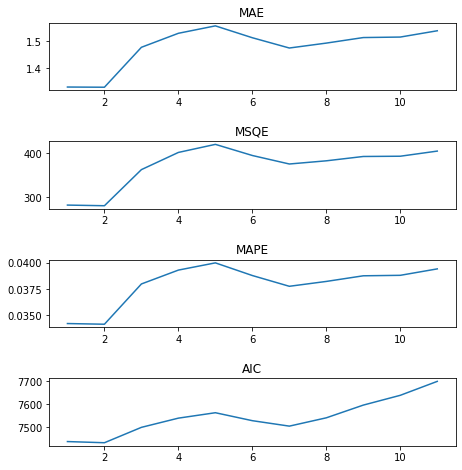

In [82]:
Average_MAPE = []
CrossVal_MAPE = []
Average_MAE = []
CrossVal_MAE = []
Average_MSQE = []
CrossVal_MSQE = []
Average_AIC = []
CrossVal_AIC = []

for j in range(11):
    for i in range(20):
        CrossVal_MAPE.append(list(list(lista[i].values())[0][j].values())[0][0])
        CrossVal_MAE.append(list(list(lista[i].values())[0][j].values())[0][1])
        CrossVal_MSQE.append(list(list(lista[i].values())[0][j].values())[0][2])
        CrossVal_AIC.append(list(list(lista[i].values())[0][j].values())[0][3])
    Average_MAPE.append(np.mean(CrossVal_MAPE))
    Average_MAE.append(np.mean(CrossVal_MAE))
    Average_MSQE.append(np.mean(CrossVal_MSQE))
    Average_AIC.append(np.mean(CrossVal_AIC))
Verdadeiros_Erros = pd.DataFrame([Average_MAPE,Average_MAE,Average_MSQE,Average_AIC],index=['MAE','MSQE','MAPE','AIC']) 
Verdadeiros_Erros.columns = Verdadeiros_Erros.columns+1
fig, axs = plt.subplots(4,figsize = (7,7))
fig.tight_layout(pad=3.0)
axs[0].title.set_text("MAE")
axs[1].title.set_text("MSQE")
axs[2].title.set_text("MAPE")
axs[3].title.set_text("AIC")
axs[0].plot(Verdadeiros_Erros.transpose()['MAE'])
axs[1].plot(Verdadeiros_Erros.transpose()['MSQE'])
axs[2].plot(Verdadeiros_Erros.transpose()['MAPE'])
axs[3].plot(Verdadeiros_Erros.transpose()['AIC'])

### Importante ressaltar que, nesse caso, o 2º LAG aparenta ser o mais recomendado por todas as métricas, e o 9º LAG continua sendo um dos melhores para se utilizar, porem não mais o melhor. Sendo assim, vale a pena realizar uma última projeção!!!

# Agora vamos comparar os 3 modelos!

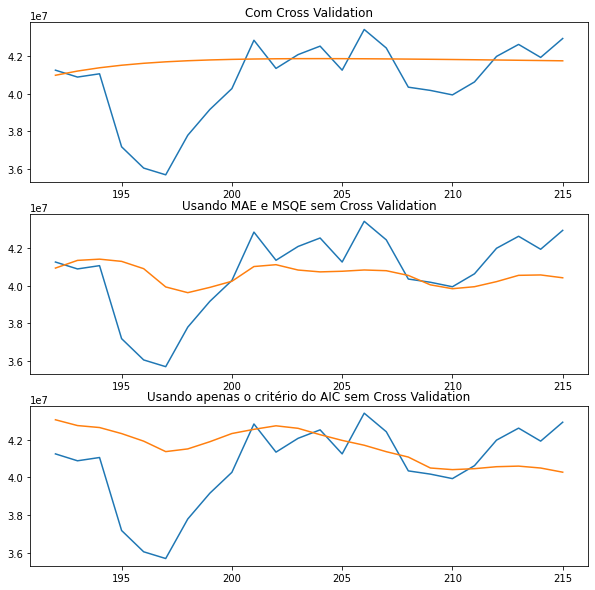

In [78]:
var_model = VARMAX(train_df,order =(2,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
test_vs_pred_após_CrossVal = pd.concat([test_df['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']],axis=1)
fig, axs = plt.subplots(3, figsize = (10,10))
axs[0].plot(test_vs_pred_após_CrossVal)
axs[0].title.set_text('Com Cross Validation')
axs[1].plot(test_vs_pred_após_teste)
axs[1].title.set_text('Usando MAE e MSQE sem Cross Validation')
axs[2].plot(test_vs_pred)
axs[2].title.set_text('Usando apenas o critério do AIC sem Cross Validation')

d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization

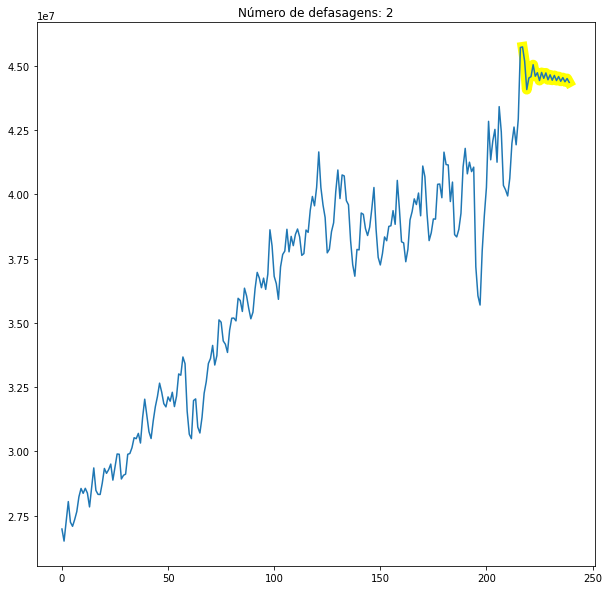

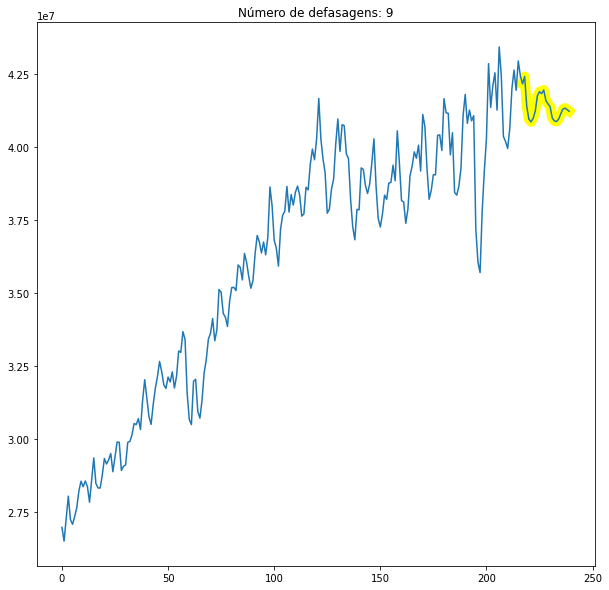

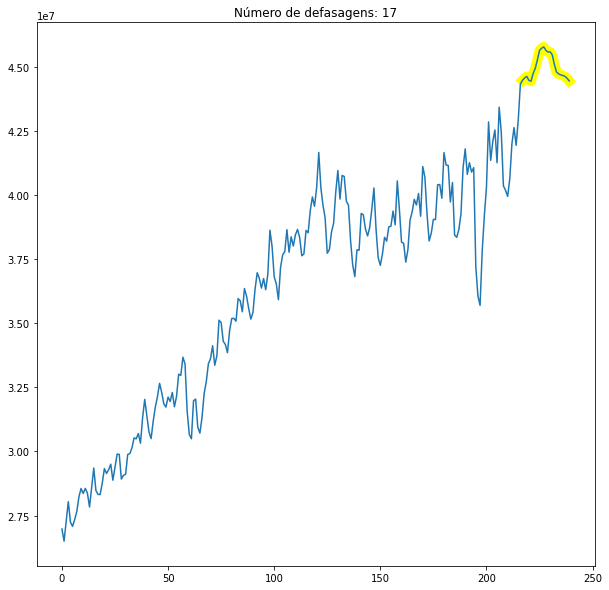

In [79]:
for i in [2,9,17]:
    var_model = VARMAX(df_energia[['PIB','Consumo de Energia Nacional']],order =(i,0), enforce_stationarity=True)
    fitted_model = var_model.fit(disp=False)
    predict = fitted_model.get_prediction(start=len(df_energia),end=len(df_energia) + 24 -1)
    predictions = predict.predicted_mean
    predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
    Forecast = pd.concat([df_energia['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']])
    fig, axs = plt.subplots(1,figsize=(10,10))
    
    axs.plot(Forecast[217:240], lw=10, c='yellow', zorder=-1)
    axs.plot(Forecast)
    axs.title.set_text(f'Número de defasagens: {i}')

In [84]:
var_model = VARMAX(df_energia[['PIB','Consumo de Energia Nacional']],order =(2,0), enforce_stationarity=True)
fitted_model = var_model.fit(disp=False)
predict = fitted_model.get_prediction(start=len(df_energia),end=len(df_energia) + 24 -1)
predictions = predict.predicted_mean
predictions.rename(columns = {'PIB':'PIB_Forecast','Consumo de Energia Nacional':'Consumo de Energia Nacional_Forecast'},inplace=True)
Forecast = pd.concat([df_energia['Consumo de Energia Nacional'],predictions['Consumo de Energia Nacional_Forecast']])

d:\python\lib\site-packages\statsmodels\tsa\statespace\varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\python\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [90]:
print((Forecast[215+12]-Forecast[215])/Forecast[215])
print((Forecast[215+24]-Forecast[216+11])/Forecast[216+11])

0.036842569385131516
-0.0035466317461007226
